In [ ]:
import os
import requests
import h5py
import numpy as np
import MAS_library as MASL
import sys

# Read snapshot number from command line argument if given
if len(sys.argv) > 1:
    snapshot_number = int(sys.argv[1])
else:
    snapshot_number = 55  # default

# === CONFIGURATION ===
api_key = "a6e92d93311aa4bd2349be55ec31c930"
num_chunks = 600
output_dir = "/gpfs/nchugh/DMCOORDS"
base_url = "https://www.tng-project.org/api/TNG300-1/files"
cutout_query = "dm=Coordinates"

# Density field params (3D)
grid = 256
BoxSize = 205.0  # Mpc/h
MAS = 'CIC'
verbose = True

# Headers for API authentication
headers = {"api-key": api_key}

# Make sure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize 3D density field grid
delta = np.zeros((grid, grid, grid), dtype=np.float32)

# Function to load DM particle coordinates from chunk file
def load_particle_positions(filename):
    with h5py.File(filename, 'r') as f:
        pos = f['PartType1']['Coordinates'][:]  # shape (N_particles, 3)
    return pos.astype(np.float32)

# Loop over chunks
for chunk in range(num_chunks):
    file_url = f"{base_url}/snapshot-{snapshot_number}.{chunk}.hdf5?{cutout_query}"
    output_path = os.path.join(output_dir, f"snap{snapshot_number}_{chunk}.hdf5")

    print(f"⬇️  Downloading chunk {chunk}/{num_chunks - 1}...")

    try:
        # Download chunk with API key header
        with requests.get(file_url, headers=headers, stream=True) as r:
            r.raise_for_status()
            with open(output_path, "wb") as f_out:
                for chunk_data in r.iter_content(chunk_size=8192):
                    f_out.write(chunk_data)

        # Load 3D particle positions
        pos = load_particle_positions(output_path)

        # Add particles to density grid with CIC assignment
        MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)

        # Remove chunk file to save space
        os.remove(output_path)

        print(f"✅ Processed chunk {chunk}")

    except Exception as e:
        print(f"❌ Failed on chunk {chunk}: {e}")

# Normalize density to overdensity
mean_delta = np.mean(delta, dtype=np.float64)
delta /= mean_delta
delta -= 1.0

# Save overdensity field
output_field_path = os.path.join(output_dir, f"field_256_{snapshot_number}.npy")
np.save(output_field_path, delta)

print("✅ Finished all chunks and computed 3D overdensity field.")
print(f"✅ Saved overdensity field to {output_field_path}")



⬇️  Downloading chunk 0/599...
⬇️  Downloading chunk 1/599...
⬇️  Downloading chunk 2/599...
⬇️  Downloading chunk 3/599...
⬇️  Downloading chunk 4/599...
⬇️  Downloading chunk 5/599...
⬇️  Downloading chunk 6/599...
⬇️  Downloading chunk 7/599...
⬇️  Downloading chunk 8/599...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import MAS_library as MASL
import os

def load_subhalo_positions(snapshot_number, mass_cut=0.1):
    csv_path = f"/gpfs/nchugh/groupcat/subhalos_snap_{snapshot_number}.csv"
    
    # Load CSV and filter by stellar mass
    df = pd.read_csv(csv_path)
    df_filtered = df[df['SubhaloStellarMass'] >= mass_cut]
    
    # Extract positions as float32
    positions = df_filtered[['SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2']].values
    return positions.astype(np.float64)

def compute_cic(snapshot_number, grid=512, BoxSize=1000.0, mass_cut=0.1, MAS='CIC'):
    # Load positions
    pos = load_subhalo_positions(snapshot_number, mass_cut=mass_cut)
    
    # Initialize density field
    delta = np.zeros((grid, grid, grid), dtype=np.float64)
    
    # Apply Cloud-In-Cell mass assignment
    MASL.MA(pos, delta, BoxSize, MAS)
    
    # Convert to overdensity field
    delta /= np.mean(delta, dtype=np.float64)
    delta -= 1.0
    
    return delta

# Example usage
if __name__ == "__main__":
    snapshot = 99  # replace with your snapshot number
    delta_field = compute_cic(snapshot, grid=256, BoxSize=205.0, mass_cut=0.1)
    
    # Optional: Save to file
    np.save(f"delta_snapshot_{snapshot}.npy", delta_field)

KeyError: 'SubhaloStellarMass'

In [16]:
import pandas as pd

# Load a CSV file containing subhalo data
df = pd.read_csv("/gpfs/nchugh/groupcat/subhalos_snap_99.csv")
# Display the first few rows of the DataFrame
print(df.head())

   SubhaloFlag   SubhaloMass  SubhaloSFR  SubhaloParent  SubhaloPos_0  \
0         True  128334.60000         0.0              0     43718.812   
1         True   36333.29000         0.0              0     45442.273   
2         True     896.40430         0.0              0     44490.760   
3         True     494.98630         0.0              0     43820.785   
4         True     467.46405         0.0              0     44302.580   

   SubhaloPos_1  SubhaloPos_2  SubhaloStarMetallicity  SubhaloGasMetallicity  \
0     48813.640     147594.95                0.020017               0.003206   
1     51850.200     146416.50                0.017918               0.003881   
2     49091.715     147870.58                0.025681               0.000000   
3     50939.400     147711.05                0.019654               0.000000   
4     49630.973     147869.48                0.020799               0.000000   

   SubhaloMassStars  ...  SubhaloVel_0  SubhaloVel_1  SubhaloVel_2  \
0        5

In [17]:
# Convert the csv file to a pkl file

df.to_pickle("/gpfs/nchugh/groupcat/subhalos_snap_99.pkl")

In [19]:
# Read the pickle file
hey = pd.read_pickle("/gpfs/nchugh/groupcat/subhalos_snap_99.pkl")
print(hey.dtypes)

SubhaloFlag                  bool
SubhaloMass               float64
SubhaloSFR                float64
SubhaloParent               int64
SubhaloPos_0              float64
SubhaloPos_1              float64
SubhaloPos_2              float64
SubhaloStarMetallicity    float64
SubhaloGasMetallicity     float64
SubhaloMassStars          float64
SubhaloMassBH             float64
SubhaloVel_0              float64
SubhaloVel_1              float64
SubhaloVel_2              float64
SubhaloVelDisp            float64
SubhaloGrNr                 int64
SubhaloVmax               float64
SubhaloSpin_0             float64
SubhaloSpin_1             float64
SubhaloSpin_2             float64
Redshift                  float64
dtype: object


In [21]:
# write a code to pickle all csv files and remove the original pickle files

import pandas as pd

for snap in range(50, 100):
    print(f"Processing snapshot {snap}...")
    csv_path = f"/gpfs/nchugh/groupcat/subhalos_snap_{snap}.csv"
    pkl_path = f"/gpfs/nchugh/groupcat/subhalos_snap_{snap}.pkl"
    
    # Load CSV and convert to pickle
    df = pd.read_csv(csv_path)
    df.to_pickle(pkl_path)
    
    # Remove original CSV file
    os.remove(csv_path)
    print(f"Converted {csv_path} to {pkl_path} and removed original CSV.")


Processing snapshot 50...
Converted /gpfs/nchugh/groupcat/subhalos_snap_50.csv to /gpfs/nchugh/groupcat/subhalos_snap_50.pkl and removed original CSV.
Processing snapshot 51...
Converted /gpfs/nchugh/groupcat/subhalos_snap_51.csv to /gpfs/nchugh/groupcat/subhalos_snap_51.pkl and removed original CSV.
Processing snapshot 52...
Converted /gpfs/nchugh/groupcat/subhalos_snap_52.csv to /gpfs/nchugh/groupcat/subhalos_snap_52.pkl and removed original CSV.
Processing snapshot 53...
Converted /gpfs/nchugh/groupcat/subhalos_snap_53.csv to /gpfs/nchugh/groupcat/subhalos_snap_53.pkl and removed original CSV.
Processing snapshot 54...
Converted /gpfs/nchugh/groupcat/subhalos_snap_54.csv to /gpfs/nchugh/groupcat/subhalos_snap_54.pkl and removed original CSV.
Processing snapshot 55...
Converted /gpfs/nchugh/groupcat/subhalos_snap_55.csv to /gpfs/nchugh/groupcat/subhalos_snap_55.pkl and removed original CSV.
Processing snapshot 56...
Converted /gpfs/nchugh/groupcat/subhalos_snap_56.csv to /gpfs/nchugh

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower
import MAS_library as MASL
import Pk_library as PKL

# Parameters
grid = 256
BoxSize = 205.001
MAS = 'CIC'

# Load catalogs
siren = pd.read_pickle('/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_4.00_mc_0.100.pkl')
galaxy = pd.read_pickle('/gpfs/nchugh/groupcat/subhalos_snap_50.pkl')

# Extract positions
def get_positions_siren(df):
    # Siren uses keys 'x','y','z_pos', convert kpc/h to Mpc/h
    return np.vstack([df['x'].values, df['y'].values, df['z_pos'].values]).T.astype(np.float32) / 1000

def get_positions_galaxy(df):
    # Galaxy uses 'SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2'
    return np.vstack([df['SubhaloPos_0'].values, df['SubhaloPos_1'].values, df['SubhaloPos_2'].values]).T.astype('f8') / 1000

# PYPOWER power spectrum function
def compute_pk_pypower(positions, boxsize, nmesh=grid):
    kmin = 2*np.pi/boxsize
    kmax = np.pi*nmesh/boxsize
    kedges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    # Provide list of three 1D arrays
    result = CatalogFFTPower([positions[:,0], positions[:,1], positions[:,2]], edges=kedges, ells=(0,), boxsize=boxsize, nmesh=nmesh, resampler='tsc', interlacing=2)
    k = result.poles.k
    P0 = result.poles.power[0].real
    nmodes = result.poles.nmodes
    err = P0 / np.sqrt(2 * nmodes)
    return k, P0, err

# Pylians power spectrum function
def compute_pk_pylians(positions, boxsize, nmesh=grid, MAS=MAS):
    delta = np.zeros((nmesh, nmesh, nmesh), dtype=np.float32)
    MASL.MA(positions.astype(np.float32), delta, boxsize, MAS)
    mean_delta = np.mean(delta, dtype=np.float64)
    if mean_delta > 0:
        delta /= mean_delta
        delta -= 1.0
    else:
        raise ValueError("Mean density zero or negative!")

    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    err = Pk.Pk[:,0] / np.sqrt(2 * Pk.Nmodes3D)
    return Pk.k3D, Pk.Pk[:,0], err

# Get positions arrays
pos_siren = get_positions_siren(siren)
pos_galaxy = get_positions_galaxy(galaxy)

# Compute PYPOWER spectra
k_siren_py, P_siren_py, err_siren_py = compute_pk_pypower(pos_siren, BoxSize)
k_galaxy_py, P_galaxy_py, err_galaxy_py = compute_pk_pypower(pos_galaxy, BoxSize)

# Compute Pylians spectra
k_siren_pylians, P_siren_pylians, err_siren_pylians = compute_pk_pylians(pos_siren, BoxSize)
k_galaxy_pylians, P_galaxy_pylians, err_galaxy_pylians = compute_pk_pylians(pos_galaxy, BoxSize)

# Plot PYPOWER results
plt.figure(figsize=(8,6))
plt.errorbar(k_siren_py, P_siren_py, yerr=err_siren_py, label='Siren (PYPOWER)', capsize=3, alpha=0.7)
plt.errorbar(k_galaxy_py, P_galaxy_py, yerr=err_galaxy_py, label='Galaxy (PYPOWER)', capsize=3, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Power Spectrum with PYPOWER')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot Pylians results
plt.figure(figsize=(8,6))
plt.errorbar(k_siren_pylians, P_siren_pylians, yerr=err_siren_pylians, label='Siren (Pylians)', capsize=3, alpha=0.7)
plt.errorbar(k_galaxy_pylians, P_galaxy_pylians, yerr=err_galaxy_pylians, label='Galaxy (Pylians)', capsize=3, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title('Power Spectrum with Pylians')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


KeyboardInterrupt: 

Siren objects: 71516, Galaxy objects after mass cut: 217360


ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

Exception ignored in: 'MAS_library.MAS_library.MA'
Traceback (most recent call last):
  File "/tmp/ipykernel_614236/3705577173.py", line 36, in compute_pk_pylians
ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'
/tmp/ipykernel_614236/3705577173.py:38: RuntimeWarning: invalid value encountered in divide
  delta /= mean_delta



Computing power spectrum of the field...
Time to complete loop = 0.61
Time taken = 1.03 seconds


ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

Exception ignored in: 'MAS_library.MAS_library.MA'
Traceback (most recent call last):
  File "/tmp/ipykernel_614236/3705577173.py", line 36, in compute_pk_pylians
ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'



Computing power spectrum of the field...
Time to complete loop = 0.63
Time taken = 1.04 seconds


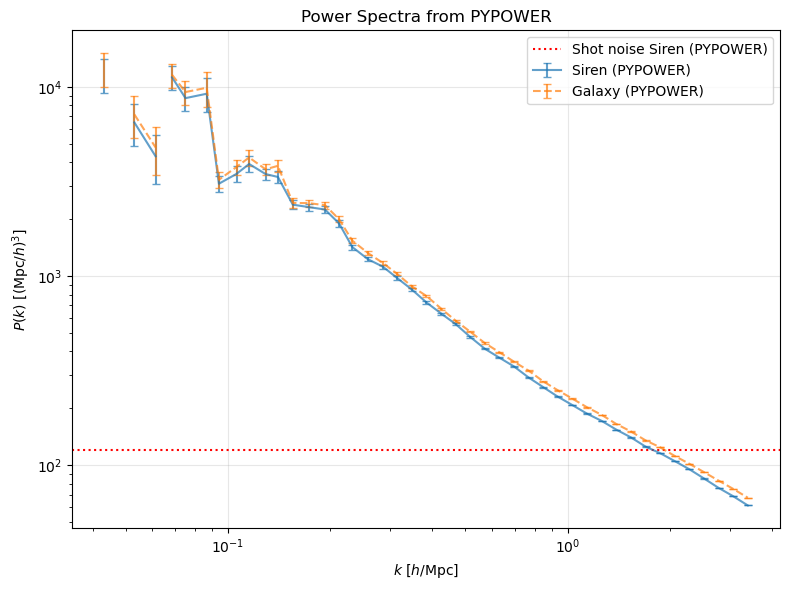

/gpfs/nchugh/anaconda3/envs/gw_env/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x1555108319d0> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 800x600 with 1 Axes>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower
import MAS_library as MASL
import Pk_library as PKL

def load_positions_siren(fname):
    df = pd.read_pickle(fname)
    pos = np.vstack([df['x'], df['y'], df['z_pos']]).T / 1000  # convert kpc/h to Mpc/h
    return pos.astype('f8')

def load_positions_galaxy(fname, mass_cut=0.1):
    df = pd.read_pickle(fname)
    df = df[df['SubhaloMassStars'] > mass_cut]
    pos = np.vstack([df['SubhaloPos_0'], df['SubhaloPos_1'], df['SubhaloPos_2']]).T / 1000
    return pos.astype('f8'), len(df)

def compute_pk_pypower(positions, boxsize, nmesh=256, edges=None):
    if edges is None:
        kmin = 2*np.pi/boxsize
        kmax = np.pi*nmesh/boxsize
        edges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    result = CatalogFFTPower([positions[:,0], positions[:,1], positions[:,2]],  # <-- list of arrays here
                             edges=edges, ells=(0,), boxsize=boxsize, nmesh=nmesh,
                             resampler='tsc', interlacing=2)
    k = result.poles.k
    P0 = result.poles.power[0].real
    nmodes = result.poles.nmodes
    shotnoise = result.poles.shotnoise
    err = P0 / np.sqrt(2*nmodes)
    return k, P0, err, shotnoise

def compute_pk_pylians(positions, boxsize, grid=256, MAS='CIC'):
    delta = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(positions, delta, boxsize, MAS)
    mean_delta = np.mean(delta, dtype=np.float64)
    delta /= mean_delta
    delta -= 1.0
    Pk = PKL.Pk(delta, boxsize, axis=0, MAS=MAS, threads=1)
    k = Pk.k3D
    P0 = Pk.Pk[:,0]
    err = P0 / np.sqrt(2 * Pk.Nmodes3D)
    return k, P0, err

def plot_power_spectra(k1, P1, err1, label1, k2, P2, err2, label2, shot1=None, title=''):
    plt.figure(figsize=(8,6))
    plt.errorbar(k1, P1, yerr=err1, label=label1, capsize=3, alpha=0.7)
    plt.errorbar(k2, P2, yerr=err2, label=label2, capsize=3, alpha=0.7, linestyle='--')
    if shot1 is not None:
        plt.axhline(shot1, color='red', linestyle=':', label=f'Shot noise {label1}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
    plt.legend()
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Parameters
boxsize = 205.001
nmesh = 256
mass_cut = 0.1

# Load positions
pos_siren = load_positions_siren('/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_4.00_mc_0.100.pkl')
pos_galaxy, ngal = load_positions_galaxy('/gpfs/nchugh/groupcat/subhalos_snap_50.pkl', mass_cut)

print(f'Siren objects: {len(pos_siren)}, Galaxy objects after mass cut: {ngal}')

# Compute power spectra with PYPOWER
k_siren_pyp, P_siren_pyp, err_siren_pyp, shot_siren = compute_pk_pypower(pos_siren, boxsize, nmesh)
k_gal_pyp, P_gal_pyp, err_gal_pyp, shot_gal = compute_pk_pypower(pos_galaxy, boxsize, nmesh)

# Compute power spectra with PYLIANS
k_siren_pli, P_siren_pli, err_siren_pli = compute_pk_pylians(pos_siren, boxsize, nmesh)
k_gal_pli, P_gal_pli, err_gal_pli = compute_pk_pylians(pos_galaxy, boxsize, nmesh)

# Plot PYPOWER results
plot_power_spectra(k_siren_pyp, P_siren_pyp, err_siren_pyp, 'Siren (PYPOWER)',
                   k_gal_pyp, P_gal_pyp, err_gal_pyp, 'Galaxy (PYPOWER)',
                   shot_siren,
                   title='Power Spectra from PYPOWER')

# Plot PYLIANS results
plot_power_spectra(k_siren_pli, P_siren_pli, err_siren_pli, 'Siren (PYLIANS)',
                   k_gal_pli, P_gal_pli, err_gal_pli, 'Galaxy (PYLIANS)',
                   title='Power Spectra from PYLIANS')


Siren objects: 71516, Galaxy objects after mass cut: 217360

Computing power spectrum of the field...
Time to complete loop = 0.80
Time taken = 1.03 seconds

Computing power spectrum of the field...
Time to complete loop = 0.79
Time taken = 1.03 seconds


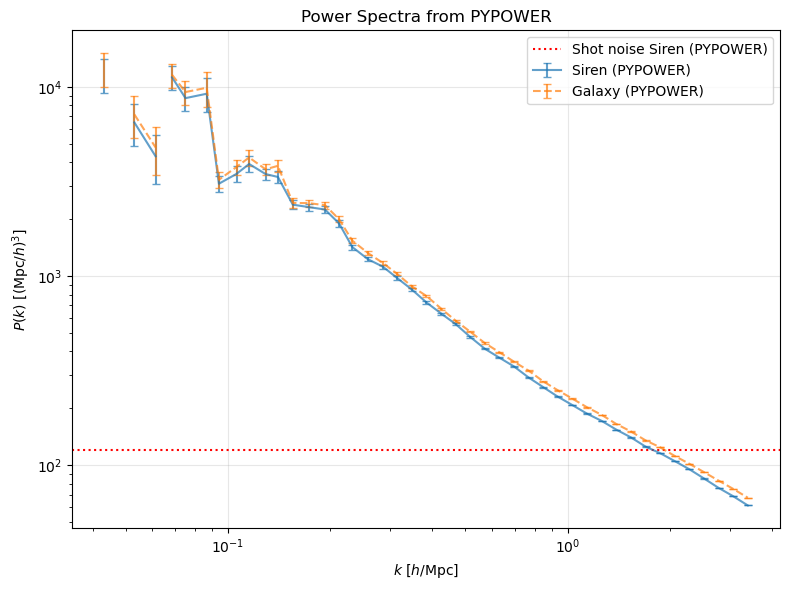

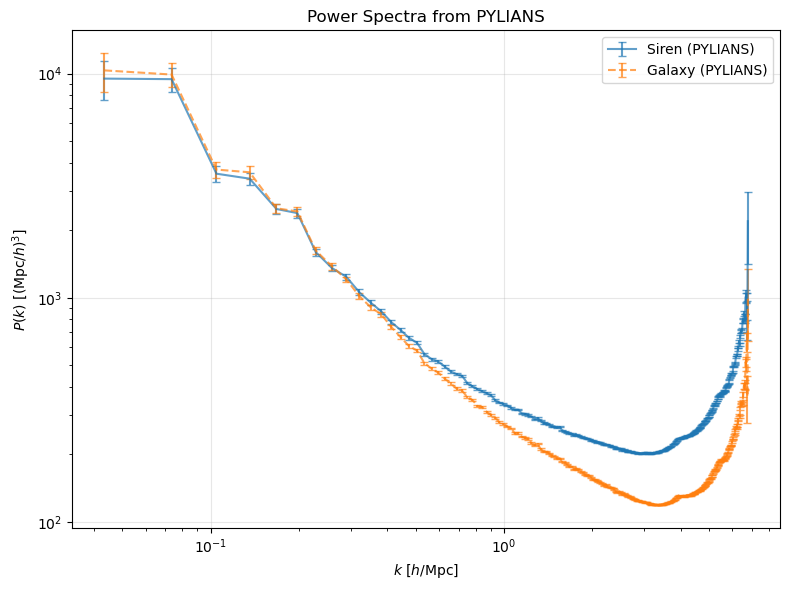

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypower import CatalogFFTPower
import MAS_library as MASL
import Pk_library as PKL

def load_positions_siren(fname):
    df = pd.read_pickle(fname)
    pos = np.vstack([df['x'], df['y'], df['z_pos']]).T / 1000  # convert kpc/h to Mpc/h
    return pos.astype('float32')

def load_positions_galaxy(fname, mass_cut=0.1):
    df = pd.read_pickle(fname)
    df = df[df['SubhaloMassStars'] > mass_cut]
    pos = np.vstack([df['SubhaloPos_0'], df['SubhaloPos_1'], df['SubhaloPos_2']]).T / 1000
    return pos.astype('float32'), len(df)

def compute_pk_pypower(positions, boxsize, nmesh=256, edges=None):
    if edges is None:
        kmin = 2*np.pi/boxsize
        kmax = np.pi*nmesh/boxsize
        edges = np.logspace(np.log10(kmin), np.log10(kmax), 50)
    result = CatalogFFTPower([positions[:,0], positions[:,1], positions[:,2]],  # list of arrays
                             edges=edges, ells=(0,), boxsize=boxsize, nmesh=nmesh,
                             resampler='tsc', interlacing=2)
    k = result.poles.k
    P0 = result.poles.power[0].real
    nmodes = result.poles.nmodes
    shotnoise = result.poles.shotnoise
    err = P0 / np.sqrt(2*nmodes)
    return k, P0, err, shotnoise

def plot_power_spectra(k1, P1, err1, label1, k2, P2, err2, label2, shot1=None, title=''):
    plt.figure(figsize=(8,6))
    eps = 1e-10  # small number to avoid log(0)
    plt.errorbar(k1, P1 + eps, yerr=err1, label=label1, capsize=3, alpha=0.7)
    plt.errorbar(k2, P2 + eps, yerr=err2, label=label2, capsize=3, alpha=0.7, linestyle='--')
    if shot1 is not None:
        plt.axhline(shot1, color='red', linestyle=':', label=f'Shot noise {label1}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
    plt.legend()
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Parameters
boxsize = 205.001
nmesh = 256
mass_cut = 0.1

# Load positions
pos_siren = load_positions_siren('/gpfs/nchugh/gw/results/siren_cat_snap_50_dl_0.90_dh_4.00_mc_0.100.pkl')
pos_galaxy, ngal = load_positions_galaxy('/gpfs/nchugh/groupcat/subhalos_snap_50.pkl', mass_cut)

print(f'Siren objects: {len(pos_siren)}, Galaxy objects after mass cut: {ngal}')

# Compute power spectra with PYPOWER
k_siren_pyp, P_siren_pyp, err_siren_pyp, shot_siren = compute_pk_pypower(pos_siren, boxsize, nmesh)
k_gal_pyp, P_gal_pyp, err_gal_pyp, shot_gal = compute_pk_pypower(pos_galaxy, boxsize, nmesh)

# Plot PYPOWER results
plot_power_spectra(k_siren_pyp, P_siren_pyp, err_siren_pyp, 'Siren (PYPOWER)',
                   k_gal_pyp, P_gal_pyp, err_gal_pyp, 'Galaxy (PYPOWER)',
                   shot_siren,
                   title='Power Spectra from PYPOWER')


Found 42 siren files for snap=50


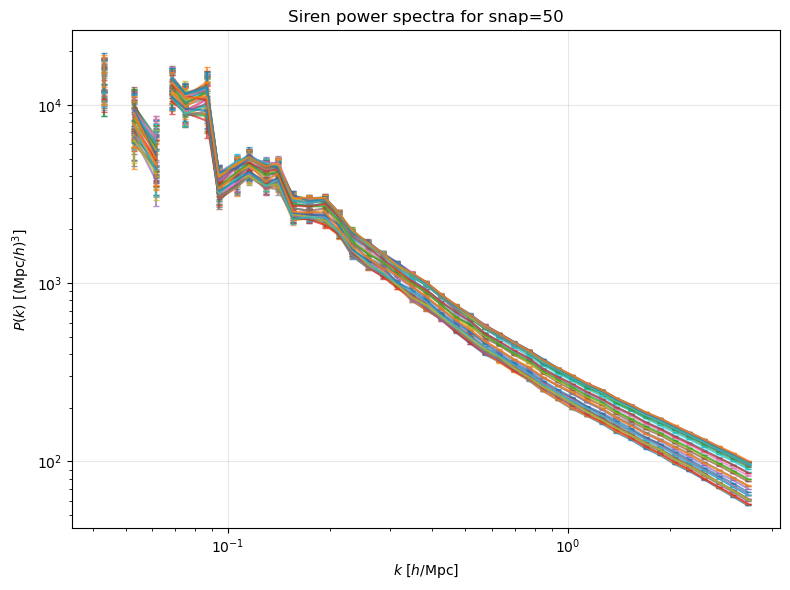

In [10]:
import glob
import os

# Parameters
snap = 50
boxsize = 205.001
nmesh = 256

# Find all siren files for snap=50
path_pattern = f'/gpfs/nchugh/gw/results/siren_cat_snap_{snap}_dl_*_dh_*_mc_*.pkl'
siren_files = sorted(glob.glob(path_pattern))

print(f'Found {len(siren_files)} siren files for snap={snap}')

plt.figure(figsize=(8,6))

for fname in siren_files:
    # Parse file name parts for label
    base = os.path.basename(fname)
    # e.g. siren_cat_snap_50_dl_0.90_dh_4.00_mc_0.100.pkl
    parts = base.split('_')
    dl = parts[4]
    dh = parts[6]
    mc = parts[8].replace('.pkl', '')
    label = f'dl={dl}, dh={dh}, mc={mc}'

    # Load positions
    pos = load_positions_siren(fname)

    # Compute power spectrum
    k, P, err, shot = compute_pk_pypower(pos, boxsize, nmesh)

    # Plot with errorbars (alpha for transparency)
    plt.errorbar(k, P, yerr=err, label=label, alpha=0.7, capsize=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$h$/Mpc]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^3$]')
plt.title(f'Siren power spectra for snap={snap}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
